# Giesekus Normal Stresses: The N₂/N₁ = -α/2 Relation

## Protocol Overview: Normal Stress Differences

In simple shear flow, the stress tensor has diagonal components τ_xx, τ_yy, τ_zz in addition to the shear stress τ_xy. The differences between these normal stresses are called **normal stress differences**:

- **First normal stress difference**: $N_1 = \tau_{xx} - \tau_{yy}$ (always positive for polymers)
- **Second normal stress difference**: $N_2 = \tau_{yy} - \tau_{zz}$ (typically negative)

**Key physics for Giesekus:**  
The Giesekus model predicts an **exact relation** between N₂ and N₁:

$$
\boxed{\frac{N_2}{N_1} = -\frac{\alpha}{2}}
$$

This ratio is:
- **Constant** (independent of shear rate γ̇)
- **Directly proportional** to the mobility parameter α
- **Zero for UCM** (α = 0), distinguishing Giesekus from Oldroyd-B

This provides the **most direct experimental route** to determine α:

$$
\alpha = -2 \cdot \frac{N_2}{N_1}
$$

**Physical manifestations:**
- N₁ > 0 causes **rod climbing** (Weissenberg effect), die swell in extrusion
- N₂ < 0 causes **secondary flows** in non-circular ducts, particle migration toward walls

## Learning Objectives

1. Understand the first and second normal stress differences (N₁, N₂)
2. Use the **exact relation N₂/N₁ = -α/2** to determine α experimentally
3. Generate synthetic normal stress data and recover α
4. Distinguish Giesekus from UCM (α=0 → N₂=0) and Oldroyd-B
5. Understand physical manifestations: rod climbing, die swell, secondary flows

## Prerequisites

- Basic RheoJAX usage (basic/01-maxwell-fitting.ipynb)
- NB 01: Giesekus flow curve (provides calibrated parameters)

## Estimated Runtime

- **Fast demo**: ~2-3 minutes (analytical predictions, no MCMC)
- **Full run**: ~10 minutes (includes parametric studies)

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import json
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.giesekus import GiesekusSingleMode

# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarning (jax.core.mapped_aval/unmapped_aval deprecated in JAX 0.8+)
warnings.filterwarnings("ignore", message=".*jax\\.core\\.(mapped|unmapped)_aval.*", category=DeprecationWarning)

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


## 2. Theory: Normal Stress Differences

### Definition

In simple shear flow, the stress tensor has the form:
$$
\boldsymbol{\sigma} = \begin{pmatrix} -p + \tau_{xx} & \tau_{xy} & 0 \\ \tau_{xy} & -p + \tau_{yy} & 0 \\ 0 & 0 & -p + \tau_{zz} \end{pmatrix}
$$

The normal stress differences are:
- **First normal stress difference**: $N_1 = \tau_{xx} - \tau_{yy}$ (always positive)
- **Second normal stress difference**: $N_2 = \tau_{yy} - \tau_{zz}$ (typically negative)

### Physical Meaning

| Effect | Cause | Observable |
|--------|-------|------------|
| **Rod climbing** (Weissenberg effect) | N₁ > 0 | Fluid climbs rotating rod |
| **Die swell** | N₁ > 0 | Extrudate expands after exiting die |
| **Secondary flow** | N₂ ≠ 0 | Circulation in non-circular ducts |
| **Shear-induced migration** | N₂ < 0 | Particles migrate toward walls |

### Giesekus Predictions

For steady shear at rate γ̇, the Giesekus model predicts:

$$N_1 = \frac{2\eta_p \dot{\gamma}^2 \lambda (1-f)}{1 + (1-2\alpha)f}$$

$$N_2 = -\alpha \cdot \frac{N_1}{2}$$

**Key relation:**
$$
\boxed{\frac{N_2}{N_1} = -\frac{\alpha}{2}}
$$

This ratio is:
- **Constant** (independent of shear rate γ̇)
- **Directly proportional** to α
- **Zero for UCM** (α = 0)

### Model Comparison

| Model | N₂/N₁ | Characteristic |
|-------|-------|----------------|
| UCM/Maxwell | 0 | No second normal stress |
| Oldroyd-B | 0 | Same as UCM for normal stresses |
| Giesekus | -α/2 | Negative, proportional to α |
| PTT | Varies | More complex dependence |
| Experimental | -0.1 to -0.3 | Polymer melts/solutions |

## 3. Load Calibrated Parameters

In [3]:
# Try to load parameters from NB01
param_file = os.path.join("..", "outputs", "giesekus", "flow_curve", "nlsq_params_flow_curve.json")

if os.path.exists(param_file):
    with open(param_file) as f:
        calibrated_params = json.load(f)
    print("Loaded calibrated parameters from NB01:")
else:
    calibrated_params = {
        "eta_p": 100.0,
        "lambda_1": 1.0,
        "alpha": 0.3,
        "eta_s": 10.0,
    }
    print("Using default parameters (run NB01 for calibrated values):")

for k, v in calibrated_params.items():
    print(f"  {k}: {v:.4g}")

alpha_true = calibrated_params["alpha"]
N2_N1_theory = -alpha_true / 2
print(f"\nTheoretical N₂/N₁ = -α/2 = {N2_N1_theory:.4f}")

Loaded calibrated parameters from NB01:
  eta_p: 2.874e+04
  lambda_1: 1e+04
  alpha: 0.003524
  eta_s: 0.2876

Theoretical N₂/N₁ = -α/2 = -0.0018


## 4. Generate Synthetic Normal Stress Data

In [4]:
# Create model with calibrated parameters
model_true = GiesekusSingleMode()
for name, val in calibrated_params.items():
    model_true.parameters.set_value(name, val)

# Shear rate range
gamma_dot = np.logspace(-2, 2, 50)  # 0.01 to 100 1/s

# Predict normal stresses
N1_clean, N2_clean = model_true.predict_normal_stresses(gamma_dot)
N1_clean = np.array(N1_clean)
N2_clean = np.array(N2_clean)

# Verify the N2/N1 ratio
ratio_clean = N2_clean / N1_clean
print(f"N₂/N₁ from model: {np.mean(ratio_clean):.6f} (theory: {N2_N1_theory:.6f})")
print(f"Ratio std dev: {np.std(ratio_clean):.2e} (should be ~0)")

N₂/N₁ from model: -0.001762 (theory: -0.001762)
Ratio std dev: 1.92e-19 (should be ~0)


In [5]:
# Add noise to simulate experimental data
rng = np.random.default_rng(42)
noise_level = 0.03  # 3% noise

noise_N1 = rng.normal(0, noise_level * np.mean(np.abs(N1_clean)), size=N1_clean.shape)
noise_N2 = rng.normal(0, noise_level * np.mean(np.abs(N2_clean)), size=N2_clean.shape)

N1_data = N1_clean + noise_N1
N2_data = N2_clean + noise_N2

print(f"N₁ range: [{N1_data.min():.2f}, {N1_data.max():.2f}] Pa")
print(f"N₂ range: [{N2_data.min():.2f}, {N2_data.max():.2f}] Pa")

N₁ range: [5.42, 6.14] Pa
N₂ range: [-0.01, -0.01] Pa


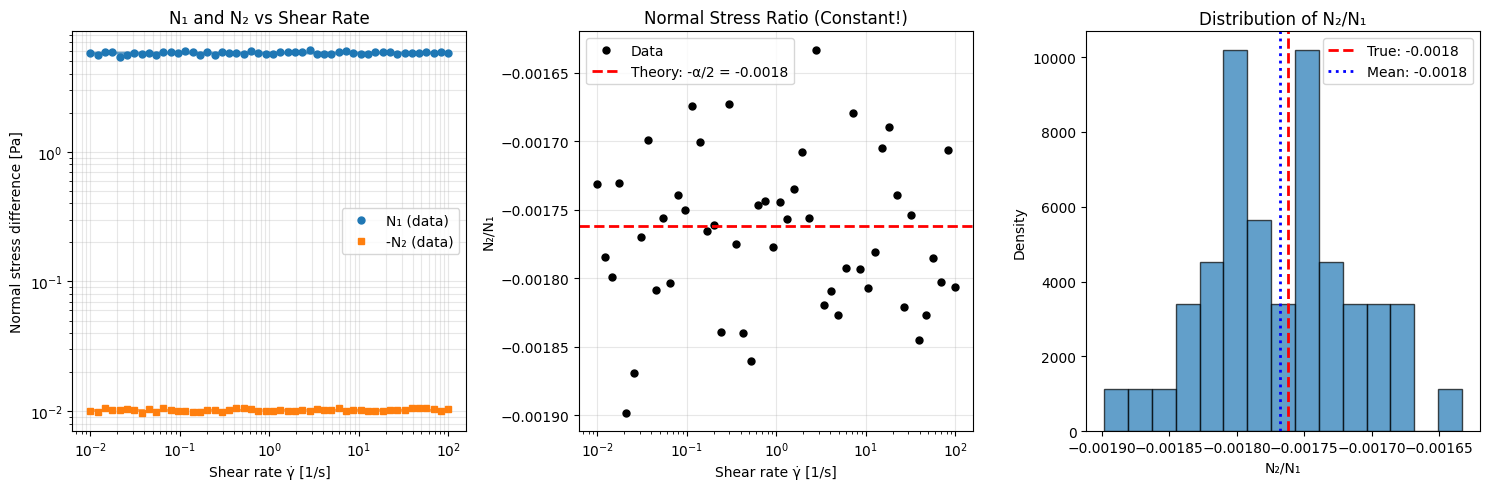

In [6]:
# Plot normal stresses
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# N1 and N2 vs shear rate
ax1 = axes[0]
ax1.loglog(gamma_dot, N1_data, "o", markersize=5, color="C0", label="N₁ (data)")
ax1.loglog(gamma_dot, -N2_data, "s", markersize=5, color="C1", label="-N₂ (data)")
ax1.loglog(gamma_dot, N1_clean, "-", lw=2, color="C0", alpha=0.7)
ax1.loglog(gamma_dot, -N2_clean, "--", lw=2, color="C1", alpha=0.7)
ax1.set_xlabel("Shear rate γ̇ [1/s]")
ax1.set_ylabel("Normal stress difference [Pa]")
ax1.set_title("N₁ and N₂ vs Shear Rate")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# N2/N1 ratio
ax2 = axes[1]
ratio_data = N2_data / N1_data
ax2.semilogx(gamma_dot, ratio_data, "ko", markersize=5, label="Data")
ax2.axhline(N2_N1_theory, color="red", linestyle="--", lw=2, label=f"Theory: -α/2 = {N2_N1_theory:.4f}")
ax2.set_xlabel("Shear rate γ̇ [1/s]")
ax2.set_ylabel("N₂/N₁")
ax2.set_title("Normal Stress Ratio (Constant!)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Histogram of ratio
ax3 = axes[2]
ax3.hist(ratio_data, bins=15, density=True, alpha=0.7, color="C0", edgecolor="black")
ax3.axvline(N2_N1_theory, color="red", linestyle="--", lw=2, label=f"True: {N2_N1_theory:.4f}")
ax3.axvline(np.mean(ratio_data), color="blue", linestyle=":", lw=2, label=f"Mean: {np.mean(ratio_data):.4f}")
ax3.set_xlabel("N₂/N₁")
ax3.set_ylabel("Density")
ax3.set_title("Distribution of N₂/N₁")
ax3.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Extract α from Normal Stress Ratio

In [7]:
# Direct extraction of α from N2/N1
# N2/N1 = -α/2  →  α = -2 * (N2/N1)

alpha_from_ratio = -2 * ratio_data

alpha_mean = np.mean(alpha_from_ratio)
alpha_std = np.std(alpha_from_ratio)

print("α Extraction from Normal Stress Ratio")
print("=" * 50)
print(f"True α:          {alpha_true:.4f}")
print(f"Extracted α:     {alpha_mean:.4f} ± {alpha_std:.4f}")
print(f"Error:           {100*abs(alpha_mean - alpha_true)/alpha_true:.2f}%")
print(f"\n95% CI: [{np.percentile(alpha_from_ratio, 2.5):.4f}, {np.percentile(alpha_from_ratio, 97.5):.4f}]")

α Extraction from Normal Stress Ratio
True α:          0.0035
Extracted α:     0.0035 ± 0.0001
Error:           0.35%

95% CI: [0.0033, 0.0037]


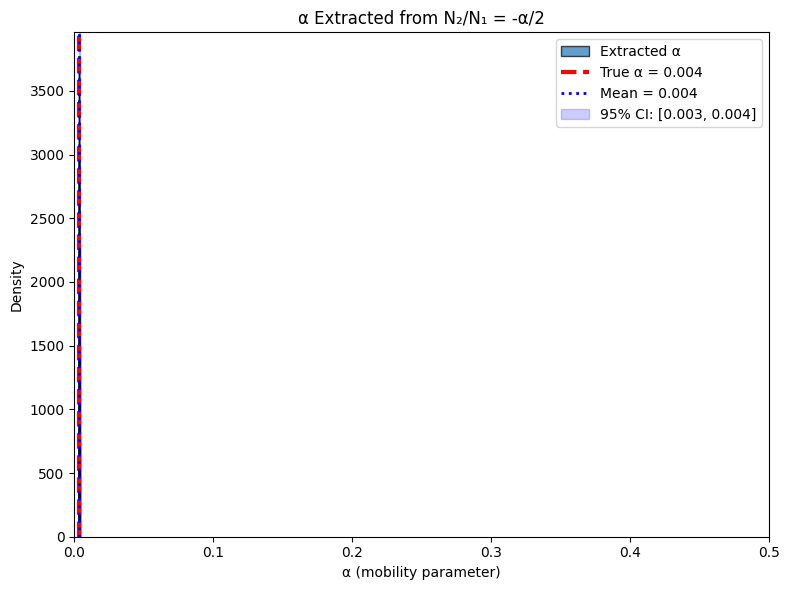

In [8]:
# Visualize α extraction
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(alpha_from_ratio, bins=20, density=True, alpha=0.7, color="C0", edgecolor="black", label="Extracted α")
ax.axvline(alpha_true, color="red", linestyle="--", lw=3, label=f"True α = {alpha_true:.3f}")
ax.axvline(alpha_mean, color="blue", linestyle=":", lw=2, label=f"Mean = {alpha_mean:.3f}")

# Shade 95% CI
lo, hi = np.percentile(alpha_from_ratio, [2.5, 97.5])
ax.axvspan(lo, hi, alpha=0.2, color="blue", label=f"95% CI: [{lo:.3f}, {hi:.3f}]")

ax.set_xlabel("α (mobility parameter)")
ax.set_ylabel("Density")
ax.set_title("α Extracted from N₂/N₁ = -α/2")
ax.legend()
ax.set_xlim(0, 0.5)

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Comparison: UCM (α=0) vs Giesekus

The key distinguishing feature of Giesekus is N₂ ≠ 0. Let's visualize this.

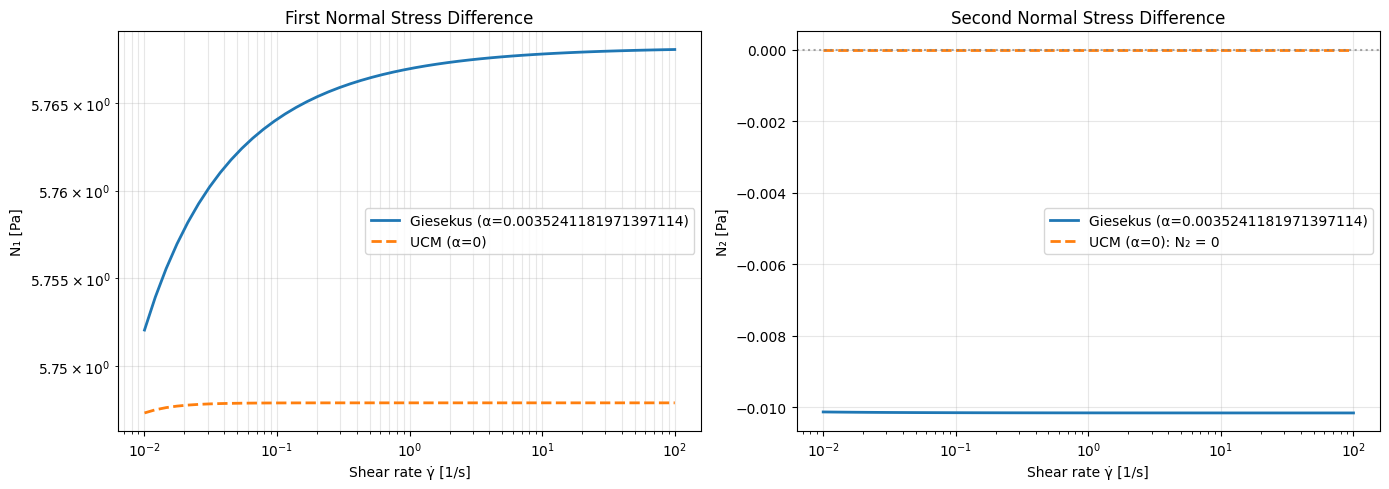

Key difference:
  UCM (α=0):     N₂ = 0 (exactly)
  Giesekus:      N₂ ≠ 0, with N₂/N₁ = -α/2 = -0.0018


In [9]:
# Compare UCM (α=0) vs Giesekus (α>0)
model_ucm = GiesekusSingleMode()
model_ucm.parameters.set_value("eta_p", calibrated_params["eta_p"])
model_ucm.parameters.set_value("lambda_1", calibrated_params["lambda_1"])
model_ucm.parameters.set_value("alpha", 0.0)  # UCM limit
model_ucm.parameters.set_value("eta_s", calibrated_params["eta_s"])

# Predict normal stresses for both
N1_ucm, N2_ucm = model_ucm.predict_normal_stresses(gamma_dot)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# N1 comparison
ax1.loglog(gamma_dot, N1_clean, "-", lw=2, color="C0", label=f"Giesekus (α={alpha_true})")
ax1.loglog(gamma_dot, N1_ucm, "--", lw=2, color="C1", label="UCM (α=0)")
ax1.set_xlabel("Shear rate γ̇ [1/s]")
ax1.set_ylabel("N₁ [Pa]")
ax1.set_title("First Normal Stress Difference")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# N2 comparison
ax2.semilogx(gamma_dot, N2_clean, "-", lw=2, color="C0", label=f"Giesekus (α={alpha_true})")
ax2.semilogx(gamma_dot, N2_ucm, "--", lw=2, color="C1", label="UCM (α=0): N₂ = 0")
ax2.axhline(0, color="gray", linestyle=":", alpha=0.7)
ax2.set_xlabel("Shear rate γ̇ [1/s]")
ax2.set_ylabel("N₂ [Pa]")
ax2.set_title("Second Normal Stress Difference")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("Key difference:")
print(f"  UCM (α=0):     N₂ = 0 (exactly)")
print(f"  Giesekus:      N₂ ≠ 0, with N₂/N₁ = -α/2 = {N2_N1_theory:.4f}")

## 7. Effect of α on Normal Stresses

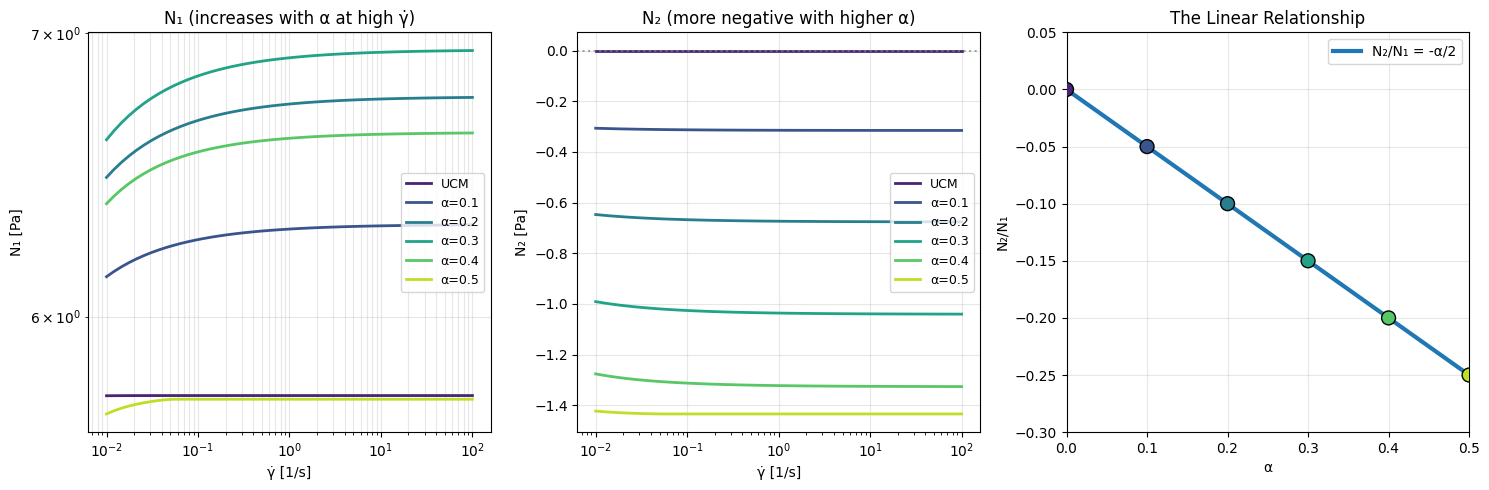

In [10]:
# Compare different α values
alpha_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(alpha_values)))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, alpha_i in enumerate(alpha_values):
    model_i = GiesekusSingleMode()
    model_i.parameters.set_value("eta_p", calibrated_params["eta_p"])
    model_i.parameters.set_value("lambda_1", calibrated_params["lambda_1"])
    model_i.parameters.set_value("alpha", alpha_i)
    model_i.parameters.set_value("eta_s", calibrated_params["eta_s"])
    
    N1_i, N2_i = model_i.predict_normal_stresses(gamma_dot)
    
    label = "UCM" if alpha_i == 0 else f"α={alpha_i}"
    
    axes[0].loglog(gamma_dot, N1_i, "-", lw=2, color=colors[i], label=label)
    axes[1].semilogx(gamma_dot, N2_i, "-", lw=2, color=colors[i], label=label)

axes[0].set_xlabel("γ̇ [1/s]")
axes[0].set_ylabel("N₁ [Pa]")
axes[0].set_title("N₁ (increases with α at high γ̇)")
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3, which="both")

axes[1].set_xlabel("γ̇ [1/s]")
axes[1].set_ylabel("N₂ [Pa]")
axes[1].set_title("N₂ (more negative with higher α)")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color="gray", linestyle=":", alpha=0.7)

# N2/N1 ratio vs α
alpha_plot = np.linspace(0, 0.5, 100)
ratio_theory = -alpha_plot / 2

axes[2].plot(alpha_plot, ratio_theory, "-", lw=3, color="C0", label="N₂/N₁ = -α/2")
axes[2].scatter(alpha_values, [-a/2 for a in alpha_values], s=100, c=colors, edgecolors="black", zorder=5)
axes[2].set_xlabel("α")
axes[2].set_ylabel("N₂/N₁")
axes[2].set_title("The Linear Relationship")
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(0, 0.5)
axes[2].set_ylim(-0.3, 0.05)

plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Physical Manifestations

Normal stresses lead to observable phenomena in polymer processing and rheometry.

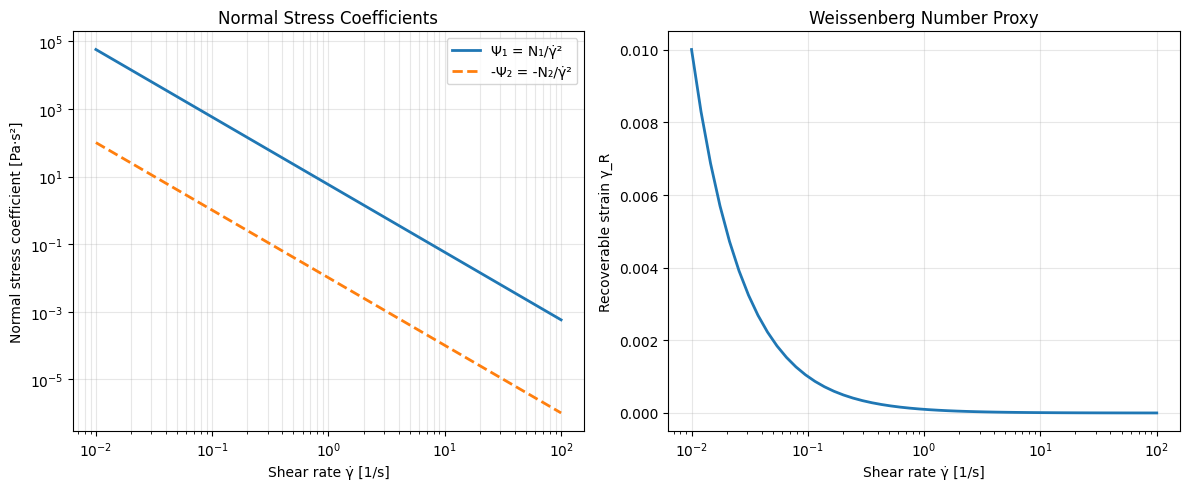

Physical Effects:
  Zero-shear Ψ₁ ≈ 57520.54 Pa·s²
  Zero-shear Ψ₂ ≈ -101.35 Pa·s²
  Ψ₂/Ψ₁ = -0.0018 (= -α/2 = -0.0018)


In [11]:
# Normal stress coefficients
# Ψ₁ = N₁/γ̇²  (first normal stress coefficient)
# Ψ₂ = N₂/γ̇²  (second normal stress coefficient)

Psi1 = N1_clean / gamma_dot**2
Psi2 = N2_clean / gamma_dot**2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Normal stress coefficients
ax1.loglog(gamma_dot, Psi1, "-", lw=2, color="C0", label="Ψ₁ = N₁/γ̇²")
ax1.loglog(gamma_dot, -Psi2, "--", lw=2, color="C1", label="-Ψ₂ = -N₂/γ̇²")
ax1.set_xlabel("Shear rate γ̇ [1/s]")
ax1.set_ylabel("Normal stress coefficient [Pa·s²]")
ax1.set_title("Normal Stress Coefficients")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Recoverable strain (Weissenberg)
# γ_R = N₁/(2σ) where σ = η·γ̇
eta = calibrated_params["eta_p"] + calibrated_params["eta_s"]
sigma = eta * gamma_dot  # Approximate
gamma_recoverable = N1_clean / (2 * sigma)

ax2.semilogx(gamma_dot, gamma_recoverable, "-", lw=2, color="C0")
ax2.set_xlabel("Shear rate γ̇ [1/s]")
ax2.set_ylabel("Recoverable strain γ_R")
ax2.set_title("Weissenberg Number Proxy")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("Physical Effects:")
print(f"  Zero-shear Ψ₁ ≈ {Psi1[0]:.2f} Pa·s²")
print(f"  Zero-shear Ψ₂ ≈ {Psi2[0]:.2f} Pa·s²")
print(f"  Ψ₂/Ψ₁ = {Psi2[0]/Psi1[0]:.4f} (= -α/2 = {N2_N1_theory:.4f})")

## 9. Save Results

In [12]:
# Save results
output_dir = os.path.join("..", "outputs", "giesekus", "normal_stresses")
os.makedirs(output_dir, exist_ok=True)

# Save extracted α
alpha_results = {
    "alpha_true": float(alpha_true),
    "alpha_extracted_mean": float(alpha_mean),
    "alpha_extracted_std": float(alpha_std),
    "N2_N1_theory": float(N2_N1_theory),
    "N2_N1_measured_mean": float(np.mean(ratio_data)),
}
with open(os.path.join(output_dir, "alpha_extraction.json"), "w") as f:
    json.dump(alpha_results, f, indent=2)

print(f"Results saved to {output_dir}/")
print(f"  alpha_extraction.json: α from N₂/N₁ ratio")

Results saved to ../outputs/giesekus/normal_stresses/
  alpha_extraction.json: α from N₂/N₁ ratio


## Key Takeaways

1. **N₂/N₁ = -α/2 is exact** for Giesekus. This ratio is constant (independent of shear rate) and provides the **most direct experimental route** to determine the mobility parameter α.

2. **N₂ ≠ 0 distinguishes Giesekus from UCM/Oldroyd-B**. Both UCM and Oldroyd-B predict N₂ = 0 exactly, making N₂ measurement a critical diagnostic.

3. **Physical manifestations**:
   - **N₁ > 0**: Rod climbing (Weissenberg effect), die swell, normal force on rheometer plates
   - **N₂ < 0**: Secondary flows in non-circular ducts, shear-induced particle migration toward walls

4. **Experimental measurement**: 
   - N₁ is relatively easy to measure with cone-and-plate or parallel-plate rheometry
   - N₂ is harder — requires cone-partitioned plate, parallel-plate edge measurements, or birefringence

5. **Typical values**: Polymer melts and solutions show N₂/N₁ ≈ -0.1 to -0.3, corresponding to α ≈ 0.2 to 0.6.

### Model Selection Guide

| Observation | Recommended Model | Key Feature |
|-------------|-------------------|-------------|
| N₂ = 0 (exactly) | UCM, Oldroyd-B | Isotropic mobility |
| N₂/N₁ = constant | **Giesekus** | Anisotropic drag, constant α |
| N₂/N₁ varies with γ̇ | PTT, FENE-P | More complex microstructure |
| N₂ unmeasurable | Carreau, Cross | Generalized Newtonian (no elasticity) |

### Experimental Techniques

| Method | Measures | Difficulty | Notes |
|--------|----------|-----------|-------|
| Cone-and-plate | N₁ | Easy | Standard rheometry |
| Parallel-plate (edge) | N₂ | Hard | Requires edge pressure sensors |
| Cone-partitioned plate | N₂ | Hard | Specialized geometry |
| Birefringence | N₁, N₂ | Hard | Optical, transparent fluids only |

### Next Steps

- **NB 05**: Creep (strain under constant stress, compliance J(t))
- **NB 06**: Stress relaxation (faster-than-Maxwell decay)
- **NB 07**: LAOS (nonlinear oscillatory, intracycle nonlinearity)

## Further Reading

**RheoJAX Documentation:**
- [Giesekus Model Reference](../../docs/source/models/giesekus/giesekus.rst) — Normal stress equations (§ Steady Shear Flow)
- [Giesekus Index](../../docs/source/models/giesekus/index.rst) — Overview and N₂/N₁ diagnostic

**Key References:**
1. Giesekus, H. (1982). "A simple constitutive equation for polymer fluids based on the concept of deformation-dependent tensorial mobility." *J. Non-Newtonian Fluid Mech.*, 11, 69-109.

2. Magda, J.J., & Baek, S.G. (1994). "Concentrated entangled and semidilute entangled polystyrene solutions and the second normal stress difference." *Polymer*, 35, 1187-1194.

3. Bird, R.B., Armstrong, R.C., & Hassager, O. (1987). *Dynamics of Polymeric Liquids, Vol. 1.* Wiley. Chapter 4.